In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../preprocessed/optimization_data.csv')
df.columns

Index(['Metro', 'Year', 'agi_by_zipcode', 'Unemployment Rate',
       'Population Per Square Mile (Land Area)', 'Arson Count',
       'Property Crimes Count', 'Violent Crimes Count', '30 yr FRM',
       '15 yr FRM', 'Good_Percentage', 'Moderate_Percentage',
       'Unhealthy_Sensitive_Percentage', 'Unhealthy_Percentage',
       'Very_Unhealthy_Percentage', 'Hazardous_Percentage',
       'Secured_Net Taxable Value', 'Unsecured_Net Taxable Value',
       'Total Taxes Levied Countywide', 'Total Population',
       'Land Area in Square Miles', 'HealthCareFacilityAmmount',
       'Hourly_Wage'],
      dtype='object')

In [4]:
# Drop columns that are not needed
df.drop(columns=['agi_by_zipcode','30 yr FRM',
       '15 yr FRM','Secured_Net Taxable Value','Unsecured_Net Taxable Value',
       'Total Taxes Levied Countywide', 'Total Population',
       'Land Area in Square Miles'],inplace=True)

In [5]:
# Normalization by min max scaler
metrics = [
    'Unemployment Rate',
    'Population Per Square Mile (Land Area)', 'Arson Count',
    'Property Crimes Count', 'Violent Crimes Count',
    'Good_Percentage', 'Moderate_Percentage', 'Unhealthy_Sensitive_Percentage',
    'Unhealthy_Percentage', 'Very_Unhealthy_Percentage', 'Hazardous_Percentage','HealthCareFacilityAmmount'
]

scaler = MinMaxScaler()
df[metrics] = scaler.fit_transform(df[metrics])

In [6]:
df

,Metro,Year,Unemployment Rate,Population Per Square Mile (Land Area),Arson Count,Property Crimes Count,Violent Crimes Count,Good_Percentage,Moderate_Percentage,Unhealthy_Sensitive_Percentage,Unhealthy_Percentage,Very_Unhealthy_Percentage,Hazardous_Percentage,HealthCareFacilityAmmount,Hourly_Wage
0,Santa Cruz-Watsonville,2021,0.284371,0.086363,0.000883,0.001166,0.000940,0.965961,0.058676,0.000000,0.000000,0.000000,0.000000,0.007196,58.10
1,San Francisco,2021,0.163513,1.000000,0.007366,0.015870,0.007403,0.222110,0.756875,0.489317,0.329470,0.086961,0.057267,0.020880,68.33
2,San Jose-Sunnyvale-Santa Clara,2021,0.145466,0.233059,0.019163,0.031732,0.021890,0.451227,0.783150,0.064220,0.000000,0.000000,0.000000,0.040276,58.67
3,Santa Maria-Santa Barbara,2021,0.210544,0.050155,0.001237,0.002716,0.002058,0.772100,0.339595,0.009174,0.000000,0.000000,0.000000,0.015034,45.65
4,Salinas,2021,0.377885,0.054789,0.001199,0.002301,0.002783,0.842291,0.241027,0.000000,0.000000,0.000000,0.000000,0.011846,34.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,Merced,2024,0.473696,0.011348,0.002017,0.001243,0.001466,0.707272,0.390693,0.091995,0.000000,0.000000,0.000000,0.007750,27.31
116,Hanford-Corcoran,2024,0.406759,0.022015,0.000063,0.000125,0.000160,0.546395,0.637790,0.055197,0.026982,0.000000,0.000000,0.004428,26.37
117,Visalia,2024,0.533414,0.015100,0.002796,0.002664,0.002474,0.380100,0.462331,0.469848,0.458566,0.264638,0.000000,0.016607,24.98
118,El Centro,2024,1.000000,0.004233,0.001576,0.003473,0.002772,0.358344,0.728739,0.390423,0.044042,0.000000,0.000000,0.004318,24.73


# Optimization
### Method1: ILP

In [7]:
def ILP(data, weights, lambda_weights, gamma_weights, user_income, affordability_ratio):
    """
    Solves the metro area selection problem using optimization.
    
    Parameters:
        data (pd.DataFrame): Filtered data for the specified year.
        weights (list): Weights for the objective function [w1, w2, w3, w4, w5, w6].
        lambda_weights (list): Weights for air quality components.
        gamma_weights (list): Weights for crime components.
        user_income (float): User's hourly income.
        affordability_ratio (float): Maximum allowable rent-to-income ratio.

    Returns:
        dict: A dictionary containing the selected metro and the objective value.
    """
    # Extract weights
    w1, w2, w3, w4, w5, w6 = weights

    # Compute Air Quality Score
    data['AirQualityScore'] = (
        lambda_weights[0] * data['Good_Percentage'] +
        lambda_weights[1] * data['Moderate_Percentage'] +
        lambda_weights[2] * data['Unhealthy_Sensitive_Percentage'] +
        lambda_weights[3] * data['Unhealthy_Percentage'] +
        lambda_weights[4] * data['Very_Unhealthy_Percentage'] +
        lambda_weights[5] * data['Hazardous_Percentage']
    )

    # Compute Crime Score
    data['CrimeScore'] = (
        gamma_weights[0] * data['Arson Count'] +
        gamma_weights[1] * data['Property Crimes Count'] +
        gamma_weights[2] * data['Violent Crimes Count']
    )

    # Initialize the model
    model = Model("Metro_Selection")

    # Decision variables
    x = model.addVars(data.index, vtype=GRB.BINARY, name="x")

    # Objective Function
    objective = quicksum(
        (w1 * data.loc[i, 'Hourly_Wage'] / user_income -
         w2 * data.loc[i, 'HealthCareFacilityAmmount'] -
         w3 * data.loc[i, 'AirQualityScore'] +
         w4 * data.loc[i, 'Unemployment Rate'] +
         w5 * data.loc[i, 'CrimeScore'] +
         w6 * data.loc[i, 'Population Per Square Mile (Land Area)']) * x[i]
        for i in data.index
    )
    model.setObjective(objective, GRB.MINIMIZE)

    # Constraints
    # Affordability Constraint
    for i in data.index:
        model.addConstr(
            x[i] * data.loc[i, 'Hourly_Wage'] <= x[i] * affordability_ratio * user_income,
            name=f"affordability_{i}"
        )

    # Only one metro area can be selected
    model.addConstr(quicksum(x[i] for i in data.index) == 1, name="select_one_metro")

    # Solve the model
    model.optimize()

    # Extract results
    if model.status == GRB.OPTIMAL:
        for i in data.index:
            if x[i].x > 0.5:  # Binary variable check
                result = {
                    "Method": "Integer Linear Programming",
                    "Selected Metro": data.loc[i, 'Metro'],
                    "Objective Value": model.objVal
                }
                return result
    else:
        return {
            "Method": "Integer Linear Programming",
            "Selected Metro": "No solution found",
            "Objective Value": np.nan}

### Method2: SA

In [8]:
def compute_objective(data, selected_index, weights, lambda_weights, gamma_weights, user_income, affordability_ratio):
    w1, w2, w3, w4, w5, w6 = weights
    
    hourly_wage_ratio = data.loc[selected_index, 'Hourly_Wage'] / user_income
    healthcare_score = data.loc[selected_index, 'HealthCareFacilityAmmount']
    air_quality_score = (data.loc[selected_index, 'Good_Percentage'] * lambda_weights[0] +
                         data.loc[selected_index, 'Moderate_Percentage'] * lambda_weights[1] +
                         data.loc[selected_index, 'Unhealthy_Sensitive_Percentage'] * lambda_weights[2] +
                         data.loc[selected_index, 'Unhealthy_Percentage'] * lambda_weights[3] +
                         data.loc[selected_index, 'Very_Unhealthy_Percentage'] * lambda_weights[4] +
                         data.loc[selected_index, 'Hazardous_Percentage'] * lambda_weights[5])
    unemployment_score = data.loc[selected_index, 'Unemployment Rate']
    crime_score = (data.loc[selected_index, 'Arson Count'] * gamma_weights[0] +
                   data.loc[selected_index, 'Property Crimes Count'] * gamma_weights[1] +
                   data.loc[selected_index, 'Violent Crimes Count'] * gamma_weights[2])
    population_score = data.loc[selected_index, 'Population Per Square Mile (Land Area)']
    
    affordability_penalty = 0
    if data.loc[selected_index, 'Hourly_Wage'] > affordability_ratio * user_income:
        affordability_penalty = 1e6
        
    return (w1 * hourly_wage_ratio 
            - w2 * healthcare_score 
            - w3 * air_quality_score 
            + w4 * unemployment_score 
            + w5 * crime_score 
            + w6 * population_score
            + affordability_penalty)

# Simulated Annealing Function
def SA(data, weights, lambda_weights, gamma_weights, user_income, affordability_ratio, max_iter=1000, initial_temp=1000, cooling_rate=0.95):
    current_solution = np.random.choice(data.index)
    current_objective = compute_objective(data, current_solution, weights, lambda_weights, gamma_weights, user_income, affordability_ratio)
    
    best_solution = current_solution
    best_objective = current_objective
    
    temperature = initial_temp
    
    for t in range(max_iter):
        # Select a neighboring solution (random other metro area)
        new_solution = np.random.choice(data.index)
        new_objective = compute_objective(data, new_solution, weights, lambda_weights, gamma_weights, user_income, affordability_ratio)
        
        # Compute change in objective
        delta = new_objective - current_objective
        
        # Acceptance probability
        if delta < 0 or np.exp(-delta / temperature) > np.random.rand():
            current_solution = new_solution
            current_objective = new_objective
            
            # Update best solution
            if current_objective < best_objective:
                best_solution = current_solution
                best_objective = current_objective
        
        # Cool down
        temperature *= cooling_rate
        
        # Stop if temperature is too low
        if temperature < 1e-3:
            break
        
    if best_objective > 1e6:
        return {"Method": "Simulated Annealing", 
                "Selected Metro": "No solution found",
                "Objective Value": np.nan}
    else:
        result = {
            "Method": "Simulated Annealing",
            "Selected Metro": data.loc[best_solution, 'Metro'],
            "Objective Value": best_objective
        }
        return result

### Results
#### Test consistency of two methods

In [9]:
# User gives the system
user_income = 70
year = 2024

# Parameters
affordability_ratio = 0.4
weights = [0.4, 0.2, 0.15, 0.1, 0.1, 0.05]
lambda_weights = [0.6, 0.4, -0.6, -0.8, -1.0, -1.2] # weights for air quality
gamma_weights = [1, 0.5, 0.7] # weights for crime rate

In [10]:
InteractiveShell.ast_node_interactivity = "all"

In [11]:
data = df[df['Year'] == year].drop(columns=['Year']).reset_index(drop=True)
ILP(data, weights, lambda_weights, gamma_weights, user_income, affordability_ratio)
SA(data, weights, lambda_weights, gamma_weights, user_income, affordability_ratio)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2557486
Academic license 2557486 - for non-commercial use only - registered to yi___@berkeley.edu
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.1.0 24B91)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2557486 - for non-commercial use only - registered to yi___@berkeley.edu
Optimize a model with 31 rows, 30 columns and 60 nonzeros
Model fingerprint: 0xd598d7b8
Variable types: 0 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e-01, 5e+01]
  Objective range  [9e-02, 5e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.1992445
Presolve removed 31 rows and 30 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 

{'Method': 'Integer Linear Programming',
 'Selected Metro': 'Chico',
 'Objective Value': 0.09752322274655895}

{'Method': 'Simulated Annealing',
 'Selected Metro': 'Chico',
 'Objective Value': 0.09752322274655895}

#### Different user scenarios

In [12]:
# 3 User Cases with Different Preferences
user_cases = [
    {"name": "Luxury-Seeking User", 
     "user_income": 120, 
     "affordability_ratio": 0.6, 
     "weights": [0.2, 0.3, 0.3, 0.1, 0.05, 0.05],  # High focus on healthcare and air quality
     "lambda_weights": [0.7, 0.4, -0.5, -0.7, -1.0, -1.2],
     "gamma_weights": [0.7, 0.5, 0.5]},

    {"name": "Safety-Conscious User", 
     "user_income": 70, 
     "affordability_ratio": 0.35, 
     "weights": [0.4, 0.2, 0.15, 0.1, 0.1, 0.05],  # Higher focus on reducing crime levels
     "lambda_weights": [0.5, 0.3, -0.7, -0.8, -1.0, -1.2],
     "gamma_weights": [1, 0.7, 0.6]},


    {"name": "Balanced Low-Income User", 
     "user_income": 35, 
     "affordability_ratio": 1, 
     "weights": [0.5, 0.15, 0.15, 0.1, 0.05, 0.05],  # Balanced affordability and living conditions
     "lambda_weights": [0.4, 0.3, -0.7, -1.0, -1.1, -1.3],
     "gamma_weights": [1.4, 0.7, 0.7]}
]

In [13]:
# Visualize User Case
user_table = pd.DataFrame(user_cases)
weights_df = pd.DataFrame(user_table["weights"].to_list(), columns=[
    "Rent-to-Income Ratio", "Healthcare Facility Availability", 
    "Air Quality", "Unemployment Rate", "Crime Levels", "Population Density"])
user_table = pd.concat([user_table.drop(["weights","lambda_weights","gamma_weights"], axis=1), weights_df], axis=1)

# Air Quality table
air_quality_table = pd.DataFrame([
    {
        "Name": case["name"],
        "User Income": case["user_income"],
        "Good": case["lambda_weights"][0],
        "Moderate": case["lambda_weights"][1],
        "Unhealthy Sensitive": case["lambda_weights"][2],
        "Unhealthy": case["lambda_weights"][3],
        "Very Unhealthy": case["lambda_weights"][4],
        "Hazardous": case["lambda_weights"][5],
    }
    for case in user_cases
])

# Crime table
crime_table = pd.DataFrame([
    {
        "Name": case["name"],
        "User Income": case["user_income"],
        "Arson": case["gamma_weights"][0],
        "Property Crimes": case["gamma_weights"][1],
        "Violent Crimes": case["gamma_weights"][2]
    }
    for case in user_cases
])

user_table
air_quality_table
crime_table

,name,user_income,affordability_ratio,Rent-to-Income Ratio,Healthcare Facility Availability,Air Quality,Unemployment Rate,Crime Levels,Population Density
0,Luxury-Seeking User,120,0.60,0.2,0.30,0.30,0.1,0.05,0.05
1,Safety-Conscious User,70,0.35,0.4,0.20,0.15,0.1,0.10,0.05
2,Balanced Low-Income User,35,1.00,0.5,0.15,0.15,0.1,0.05,0.05


,Name,User Income,Good,Moderate,Unhealthy Sensitive,Unhealthy,Very Unhealthy,Hazardous
0,Luxury-Seeking User,120,0.7,0.4,-0.5,-0.7,-1.0,-1.2
1,Safety-Conscious User,70,0.5,0.3,-0.7,-0.8,-1.0,-1.2
2,Balanced Low-Income User,35,0.4,0.3,-0.7,-1.0,-1.1,-1.3


,Name,User Income,Arson,Property Crimes,Violent Crimes
0,Luxury-Seeking User,120,0.7,0.5,0.5
1,Safety-Conscious User,70,1.0,0.7,0.6
2,Balanced Low-Income User,35,1.4,0.7,0.7


In [55]:
results = []

for case in user_cases:
    data = df[df["Year"] == 2024].reset_index(drop=True)
    result = ILP(data, case["weights"], case["lambda_weights"], case["gamma_weights"], 
                case["user_income"], case["affordability_ratio"])
    result["Year"] = year
    result["User Case"] = case["name"]
    result["User Income"] = case["user_income"]
    results.append(result)

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.1.0 24B91)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2557486 - for non-commercial use only - registered to yi___@berkeley.edu
Optimize a model with 31 rows, 30 columns and 60 nonzeros
Model fingerprint: 0xca3e31bb
Variable types: 0 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [5e-02, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0900782
Presolve removed 31 rows and 30 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: -0.141578 -0.0900782 

Optimal solution found (tolerance 1.00e-04)
Best objective -1.415781966741e-01, best bound -1.415781966741e-01, gap 

In [56]:
# Visualization
results_df = pd.DataFrame(results)
results_df = results_df.drop(columns=['Method'])
results_df = results_df[['User Case', 'User Income', 'Year', 'Selected Metro', 'Objective Value']]
print("Optimization Results under Different User Scenarios")
results_df

Optimization Results under Different User Scenarios


,User Case,User Income,Year,Selected Metro,Objective Value
0,Luxury-Seeking User,120,2024,Redding,-0.141578
1,Safety-Conscious User,70,2024,Bakersfield,0.206795
2,Balanced Low-Income User,35,2024,Chico,0.362412


In [28]:
metros_to_compare = ['Napa','Yuba City','Redding', 'Bakersfield','Chico']
data = df[df["Year"] == 2024].reset_index(drop=True)
comparison_data = data[data['Metro'].isin(metros_to_compare)].reset_index(drop=True)

In [16]:
InteractiveShell.ast_node_interactivity = "last"

In [30]:
comparison_data

,Metro,Year,Unemployment Rate,Population Per Square Mile (Land Area),Arson Count,Property Crimes Count,Violent Crimes Count,Good_Percentage,Moderate_Percentage,Unhealthy_Sensitive_Percentage,Unhealthy_Percentage,Very_Unhealthy_Percentage,Hazardous_Percentage,HealthCareFacilityAmmount,Hourly_Wage
0,Napa,2024,0.097014,0.008781,0.000089,0.000167,0.000156,0.380100,0.462331,0.469848,0.458566,0.264638,0.0,0.003543,51.62
1,Redding,2024,0.207919,0.002256,0.000037,0.000123,0.000039,1.000000,0.000000,0.015795,0.000000,0.000000,0.0,0.008414,28.60
2,Yuba City,2024,0.341340,0.003388,0.000191,0.000292,0.000259,0.754603,0.328095,0.078606,0.000000,0.000000,0.0,0.006089,28.10
3,Chico,2024,0.226293,0.023359,0.000845,0.000823,0.001024,0.792319,0.306680,0.000000,0.000000,0.053377,0.0,0.008414,27.46
4,Bakersfield,2024,0.424478,0.033388,0.010537,0.013126,0.012861,0.281593,0.693558,0.611063,0.125456,0.000000,0.0,0.025906,24.19


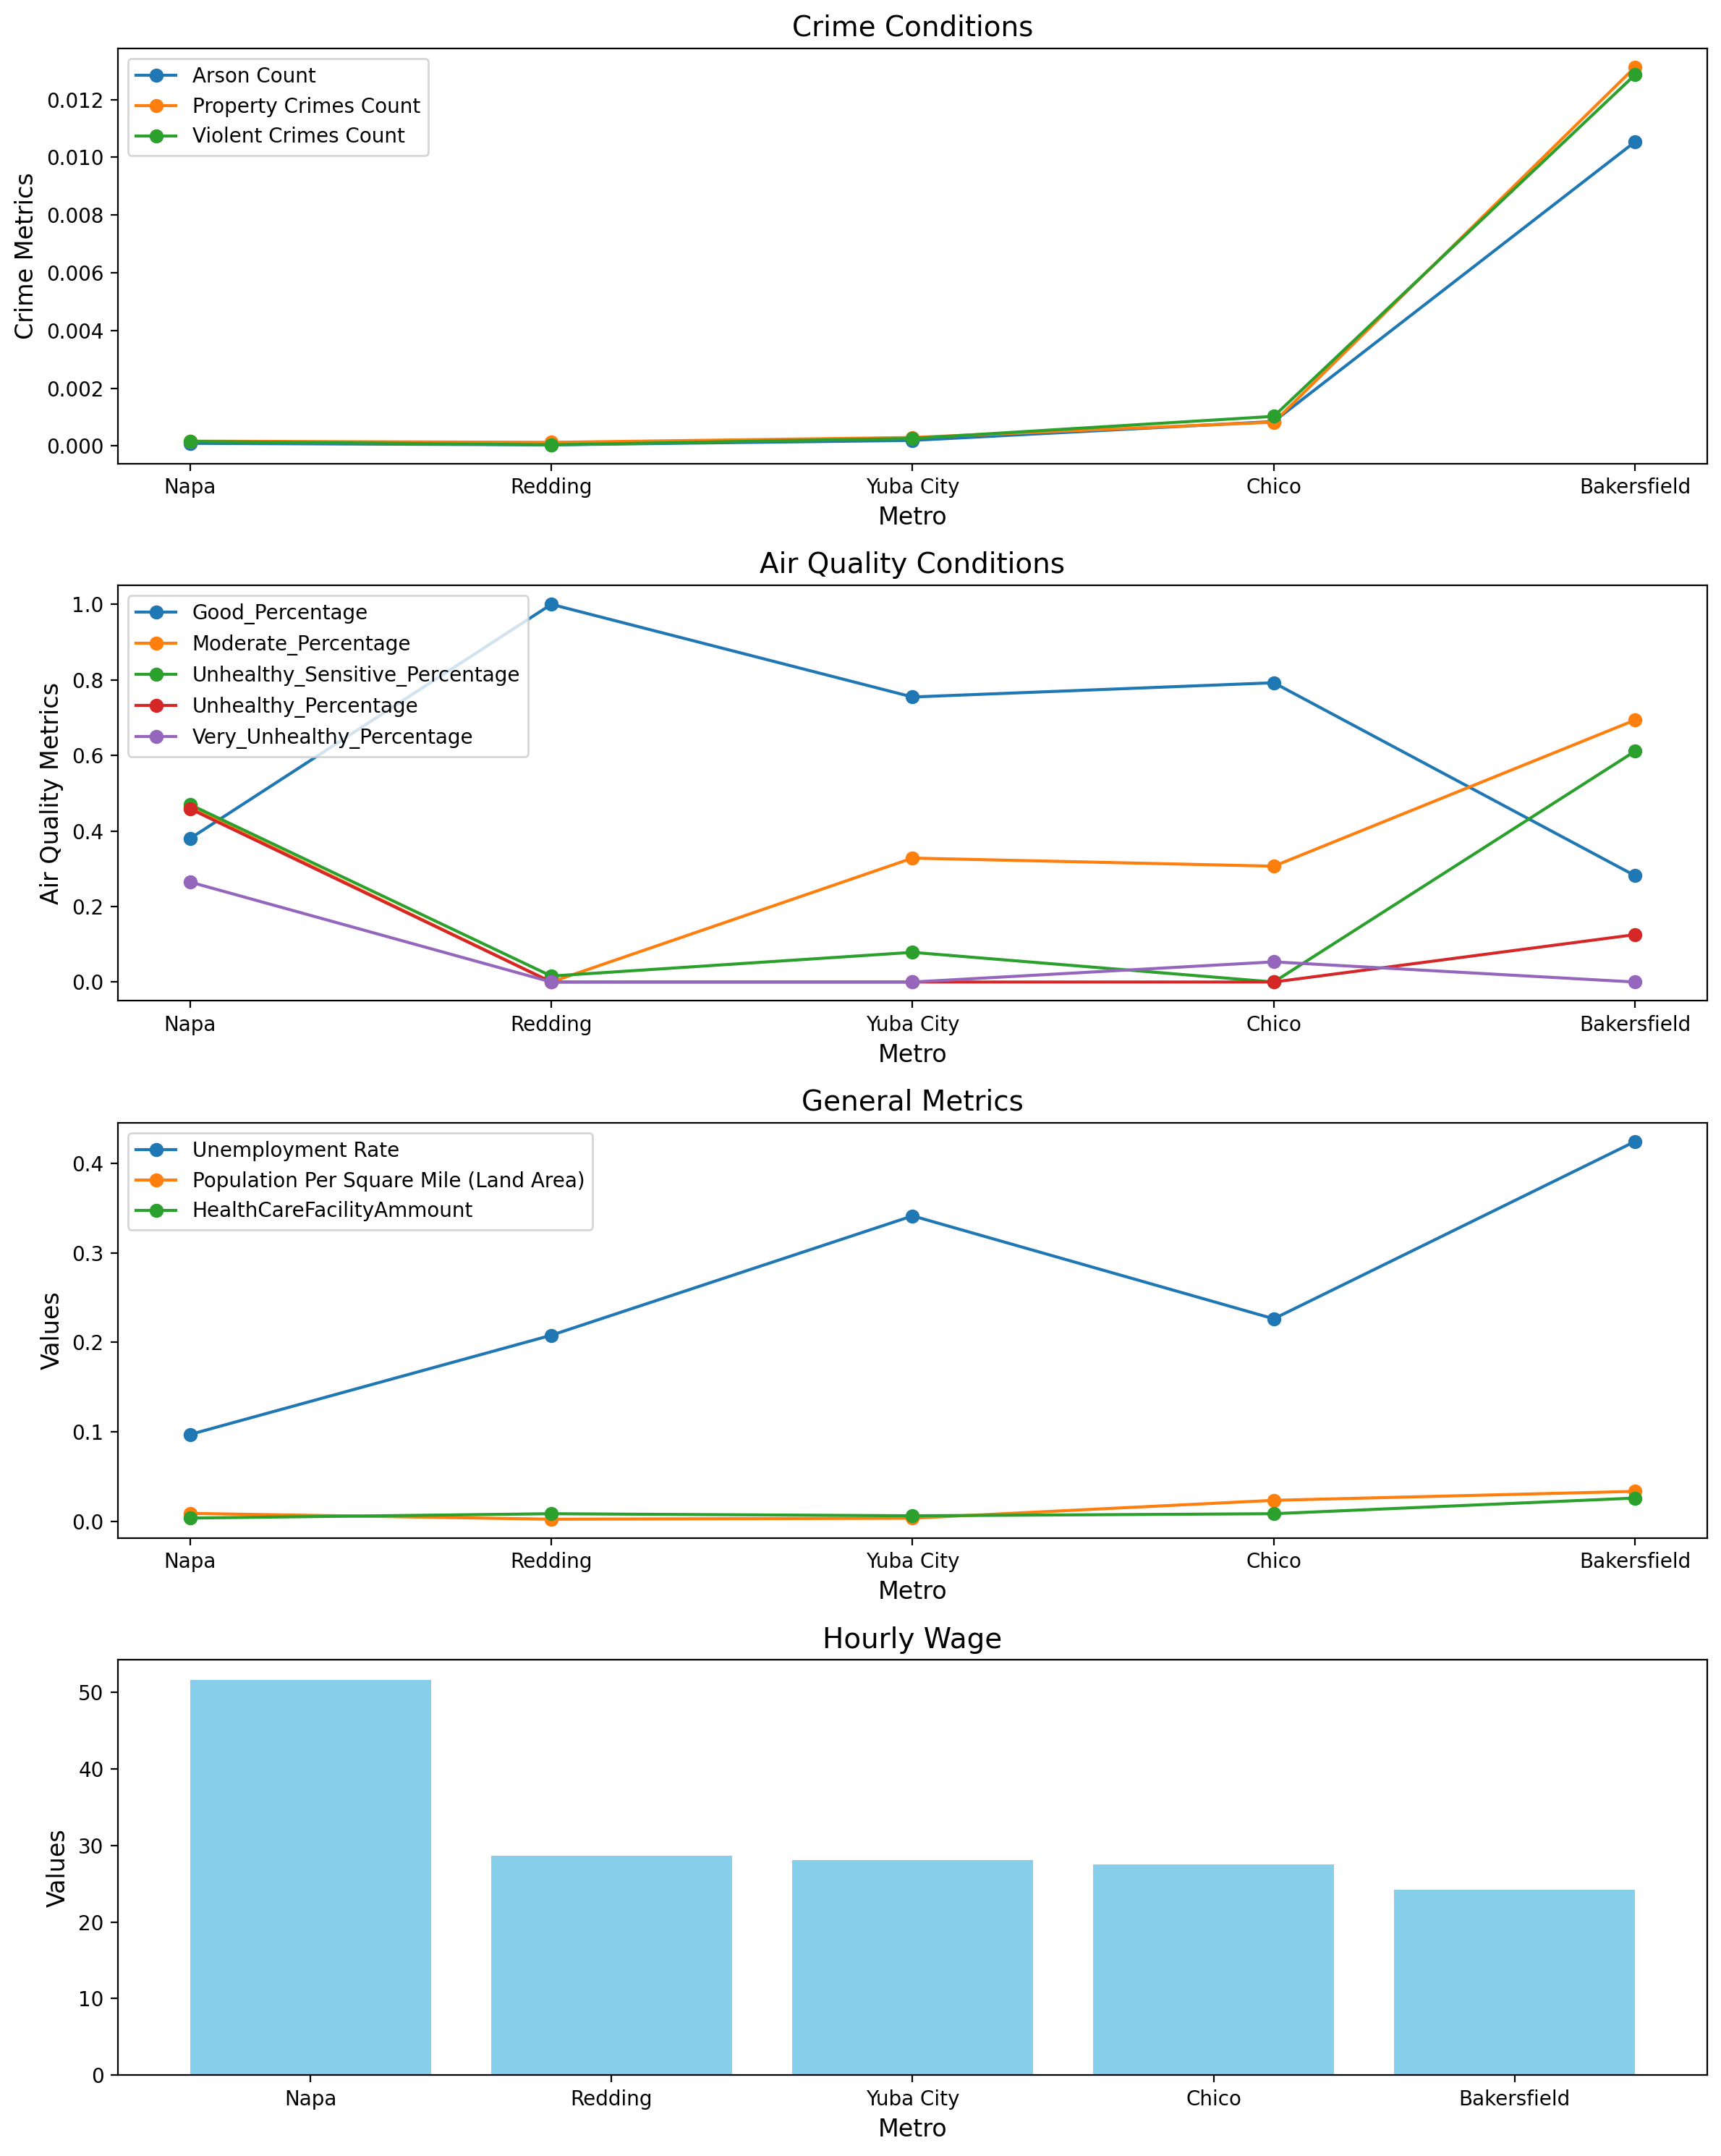

In [44]:
# Define columns
columns_to_plot = [
    "Unemployment Rate", "Population Per Square Mile (Land Area)", 
    "HealthCareFacilityAmmount"
]
crime_columns = ["Arson Count", "Property Crimes Count", "Violent Crimes Count"]
air_quality_columns = [
    "Good_Percentage", "Moderate_Percentage", "Unhealthy_Sensitive_Percentage",
    "Unhealthy_Percentage", "Very_Unhealthy_Percentage"
]

# Create a figure with subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 15), dpi=200)

# Plot crime conditions
for column in crime_columns:
    axes[0].plot(comparison_data["Metro"], comparison_data[column], marker='o', label=column)
axes[0].set_title("Crime Conditions", fontsize=14)
axes[0].set_xlabel("Metro", fontsize=12)
axes[0].set_ylabel("Crime Metrics", fontsize=12)
axes[0].legend()

# Plot air quality conditions
for column in air_quality_columns:
    axes[1].plot(comparison_data["Metro"], comparison_data[column], marker='o', label=column)
axes[1].set_title("Air Quality Conditions", fontsize=14)
axes[1].set_xlabel("Metro", fontsize=12)
axes[1].set_ylabel("Air Quality Metrics", fontsize=12)
axes[1].legend()

# Plot general metrics
for i, column in enumerate(columns_to_plot):
    axes[2].plot(comparison_data["Metro"], comparison_data[column], marker='o', label=column)
axes[2].set_title("General Metrics", fontsize=14)
axes[2].set_xlabel("Metro", fontsize=12)
axes[2].set_ylabel("Values", fontsize=12)
axes[2].legend()

axes[3].bar(comparison_data["Metro"], comparison_data["Hourly_Wage"], color='skyblue')
axes[3].set_title("Hourly Wage", fontsize=14)
axes[3].set_xlabel("Metro", fontsize=12)
axes[3].set_ylabel("Values", fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

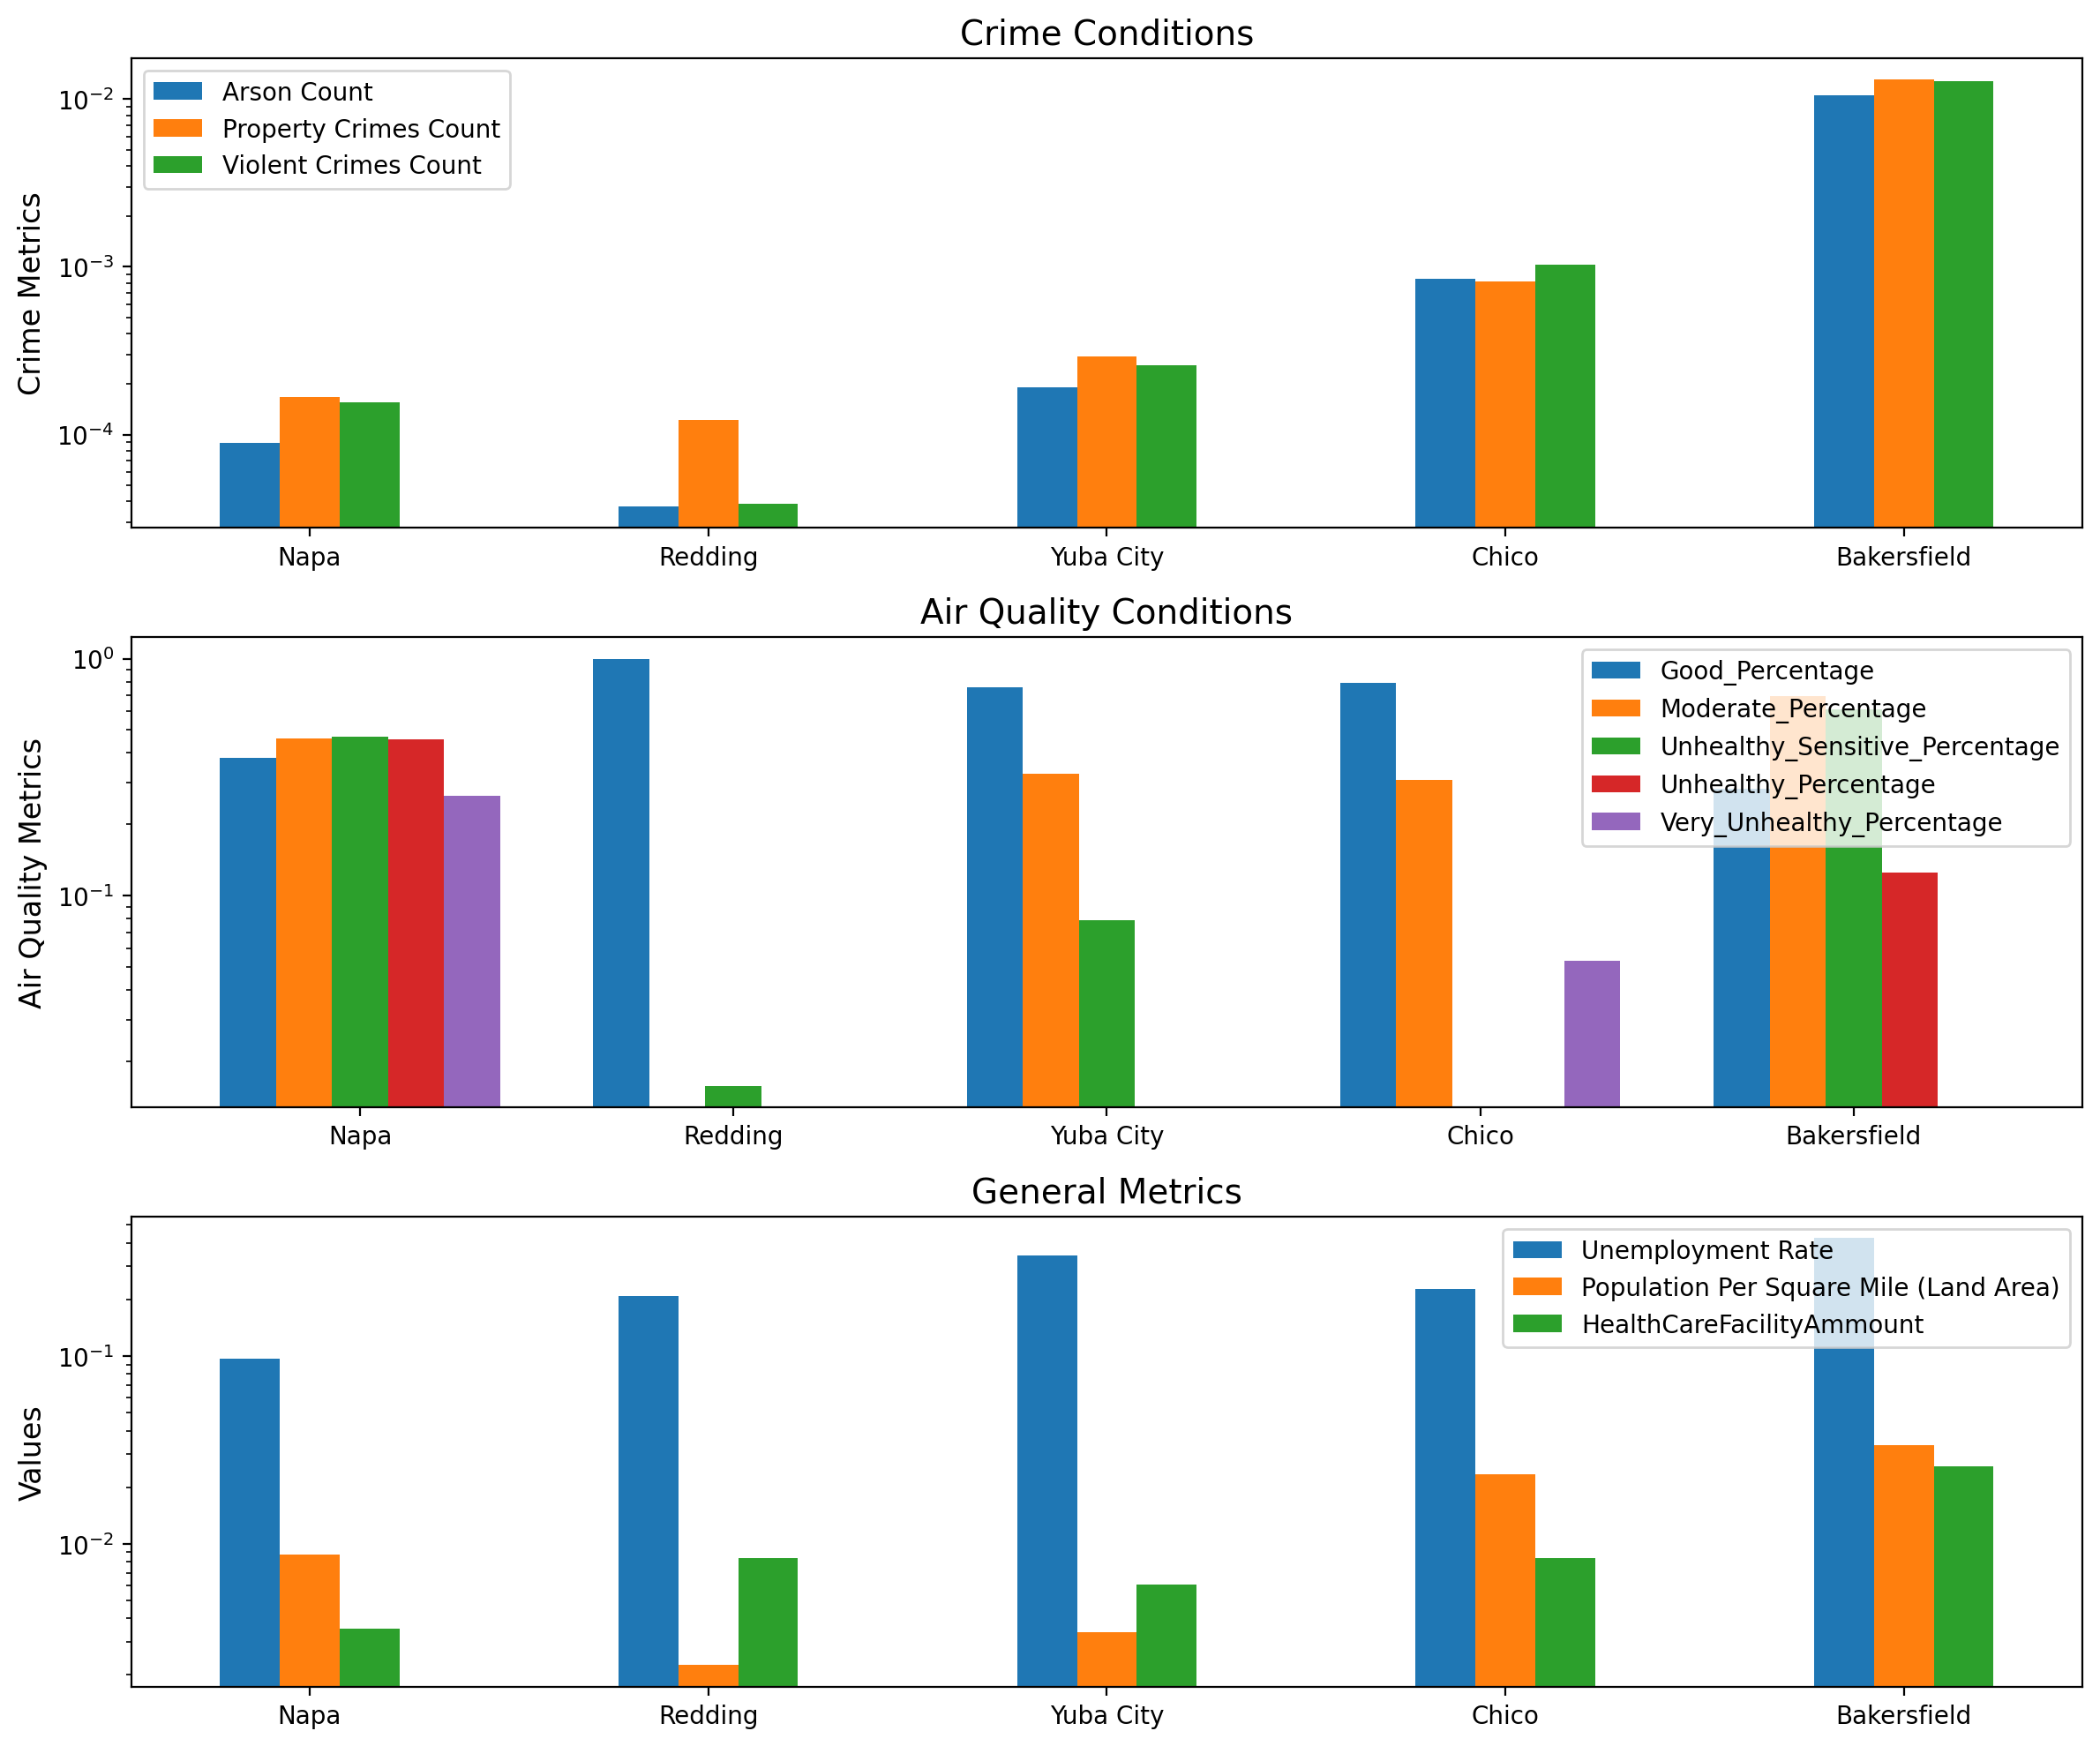

In [53]:
# Define columns
columns_to_plot = [
    "Unemployment Rate", "Population Per Square Mile (Land Area)", 
    "HealthCareFacilityAmmount"
]
crime_columns = ["Arson Count", "Property Crimes Count", "Violent Crimes Count"]
air_quality_columns = [
    "Good_Percentage", "Moderate_Percentage", "Unhealthy_Sensitive_Percentage",
    "Unhealthy_Percentage", "Very_Unhealthy_Percentage"
]

# Create a figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 10), dpi=200)

# Plot crime conditions as bar charts
bar_width = 0.15
x = range(len(comparison_data["Metro"]))

for idx, column in enumerate(crime_columns):
    axes[0].bar([i + idx * bar_width for i in x], comparison_data[column], 
                width=bar_width, label=column)
axes[0].set_title("Crime Conditions", fontsize=14)
axes[0].set_xticks([i + bar_width for i in x])
axes[0].set_xticklabels(comparison_data["Metro"])
axes[0].set_ylabel("Crime Metrics", fontsize=12)
axes[0].set_yscale("log")
axes[0].legend()

# Plot air quality conditions as bar charts
for idx, column in enumerate(air_quality_columns):
    axes[1].bar([i + idx * bar_width for i in x], comparison_data[column], 
                width=bar_width, label=column)
axes[1].set_title("Air Quality Conditions", fontsize=14)
axes[1].set_xticks([i + 2 * bar_width for i in x])
axes[1].set_xticklabels(comparison_data["Metro"])
axes[1].set_ylabel("Air Quality Metrics", fontsize=12)
axes[1].set_yscale("log")
axes[1].legend()

# Plot general metrics as bar charts
for idx, column in enumerate(columns_to_plot):
    axes[2].bar([i + idx * bar_width for i in x], comparison_data[column], 
                width=bar_width, label=column)
axes[2].set_title("General Metrics", fontsize=14)
axes[2].set_xticks([i + bar_width for i in x])
axes[2].set_xticklabels(comparison_data["Metro"])
axes[2].set_ylabel("Values", fontsize=12)
axes[2].set_yscale("log")
axes[2].legend()

# # Plot Hourly Wage as a bar chart
# axes[3].bar(comparison_data["Metro"], comparison_data["Hourly_Wage"])
# axes[3].set_title("Hourly Wage", fontsize=14)
# axes[3].set_xticklabels(comparison_data["Metro"])
# axes[3].set_ylabel("Values", fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()